# Introduction aux Embeddings

Les embeddings sont des représentations numériques continues des mots ou tokens dans un espace vectoriel. Ils permettent de capturer des relations sémantiques et syntaxiques entre les mots.

## Types d'Embeddings :
1. **Embeddings statiques** (e.g., Word2Vec) :
   - Un mot a une représentation unique, quel que soit son contexte.
   - Capturent des relations sémantiques globales mais pas de variations contextuelles.
2. **Embeddings contextuels** (e.g., BERT, GPT) :
   - Les vecteurs changent en fonction du contexte dans lequel le mot apparaît.
   - Capturent des nuances sémantiques plus complexes.

Dans ce lab, nous allons :
1. Générer des embeddings statiques avec Word2Vec.
2. Utiliser des embeddings contextuels à l'aide de modèles comme BERT.


In [ ]:
# # %pip install gensim transformers
# %pip install --upgrade pip setuptools wheel
# %pip install --upgrade numpy gensim

#### Embeddings statiques (e.g., Word2Vec) :

In [2]:
from gensim.models import Word2Vec

# Exemple de corpus avec les mots nécessaires
corpus = [
    ["roi", "homme", "reine", "femme" ],
    ["roi", "reine"],
    ["roi", "homme", ],
    ["reine", "femme", ],
    ["homme"],
    ["femme"],
    ["roi", "reine"],
    ["homme", "femme", "roi", "reine"],
    ["roi", "femme", "reine", "homme"]
]


# Entraîner le modèle Word2Vec
model = Word2Vec(sentences=corpus, vector_size=50, window=3, min_count=1, sg=0)

# Vérification des mots dans le vocabulaire
vocabulaire = model.wv.key_to_index.keys()
print("Vocabulaire :", vocabulaire)


Vocabulaire : dict_keys(['reine', 'roi', 'femme', 'homme'])


In [3]:
# Trouver les mots similaires
similar_to_roi = model.wv.most_similar("roi")
similar_to_reine = model.wv.most_similar("reine")

print("Mots similaires à 'roi' :", similar_to_roi)
print("Mots similaires à 'reine' :", similar_to_reine)


Mots similaires à 'roi' : [('reine', 0.04237300902605057), ('femme', 0.011071980930864811), ('homme', -0.17424818873405457)]
Mots similaires à 'reine' : [('femme', 0.1267007291316986), ('roi', 0.042373016476631165), ('homme', -0.01447527389973402)]


In [4]:
# Calcul de l'analogie
result = model.wv.most_similar(
    positive=["roi", "femme"], 
    negative=["homme"], topn=1)
print("Résultat de l'analogie roi − homme + femme :", result)

Résultat de l'analogie roi − homme + femme : [('reine', 0.09566916525363922)]


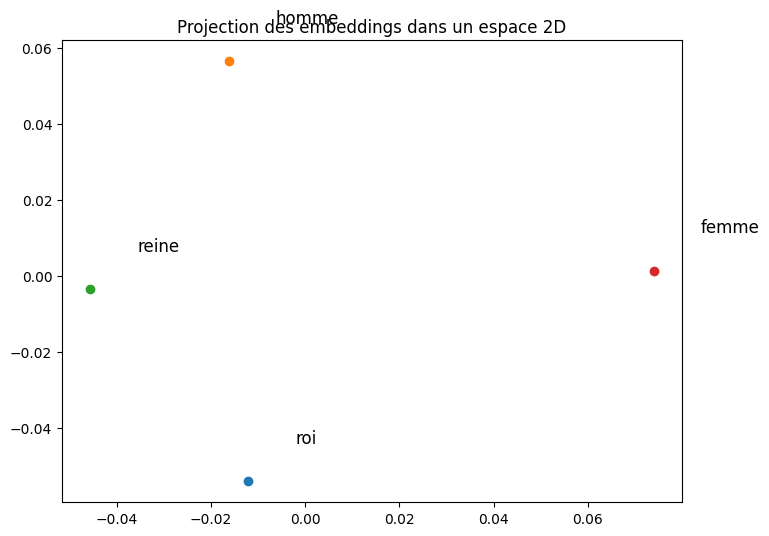

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Récupérer les vecteurs des mots
words = ["roi", "homme", "reine", "femme", "monarchie", "princesse", "prince"]
vectors = [model.wv[word] for word in vocabulaire]

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors)

# Visualisation
plt.figure(figsize=(8, 6))
for word, vec in zip(words, reduced_vectors):
    plt.scatter(vec[0], vec[1])
    plt.text(vec[0] + 0.01, vec[1] + 0.01, word, fontsize=12)
plt.title("Projection des embeddings dans un espace 2D")
plt.show()


#### Embeddings contextuels (e.g. BERT) :


In [6]:
import torch
from transformers import BertModel, BertTokenizer
import numpy as np
from scipy.spatial.distance import cosine

# Chargement du modèle BERT et du tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Création d'un corpus riche pour tester les analogies
corpus = """
The king and queen ruled their kingdom with wisdom and grace.
The man worked hard to provide for his family.
The woman led the company with remarkable vision.
The kings and queens of ancient times held great power.
Both men and women deserve equal opportunities in society.
The royal palace housed the king's throne.
Many women have achieved remarkable success in various fields.
Men face unique challenges in modern society.
The queen's coronation was a magnificent ceremony.
Gender equality benefits both men and women.
Kings throughout history have shaped their nations.
Queens have left lasting legacies in world history.
Modern men and women work together as equals.
The royal family included both kings and queens.
"""

def get_bert_embedding(word):
    # Tokenisation
    inputs = tokenizer(word, return_tensors="pt", padding=True)
    
    # Obtention des embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Utilisation de la moyenne des dernières couches cachées
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy()[0]

# Obtention des embeddings pour les mots clés
king_embedding = get_bert_embedding("king")
man_embedding = get_bert_embedding("man")
woman_embedding = get_bert_embedding("woman")
queen_embedding = get_bert_embedding("queen")

# Calcul de l'analogie
result_embedding = king_embedding - man_embedding + woman_embedding

# Fonction pour trouver les mots les plus proches
def find_closest_words(target_embedding, num_words=5):
    # Liste de mots à comparer
    vocabulary = ["queen", "man", "woman", "prince", "princess", 
                 "father", "mother", "brother", "sister", "lord", "lady",
                 "duke", "duchess", "emperor", "empress","king"]
    
    distances = []
    for word in vocabulary:
        embed = get_bert_embedding(word)
        distance = 1 - cosine(target_embedding, embed)
        distances.append((word, distance))
    
    return sorted(distances, key=lambda x: x[1], reverse=True)[:num_words]


In [7]:
# Affichage des résultats
print("Analogie: king - man + woman = ?")
closest_words = find_closest_words(result_embedding)
print("\nMots les plus proches du résultat:")
for word, similarity in closest_words:
    print(f"{word}: {similarity:.4f}")


Analogie: king - man + woman = ?

Mots les plus proches du résultat:
king: 0.9248
queen: 0.8644
princess: 0.8620
prince: 0.8615
woman: 0.8611


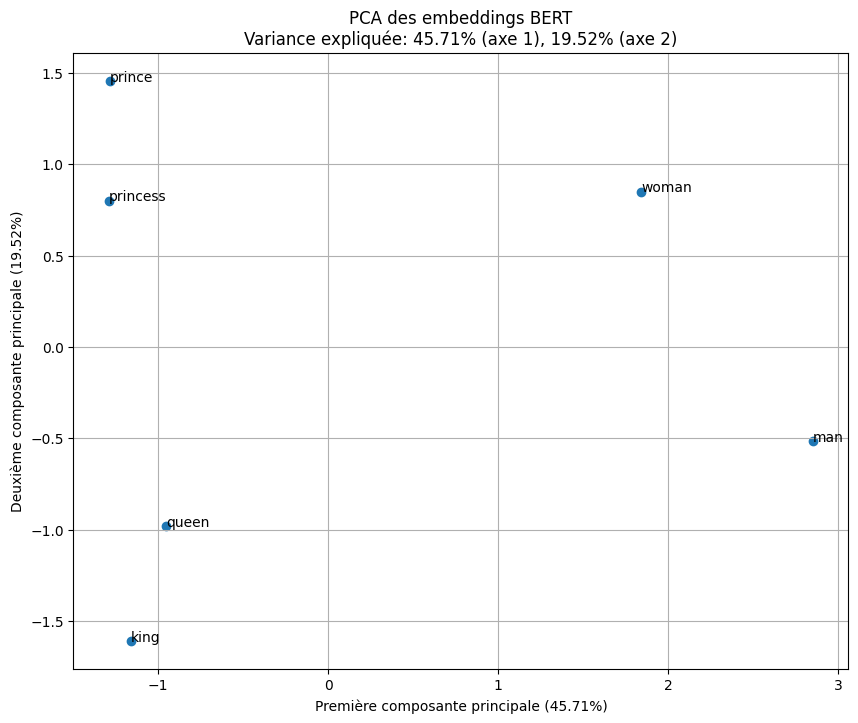

In [8]:
# Visualisation des embeddings avec PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_embeddings_pca():
    words = ["king", "queen", "man", "woman", "prince", "princess"]
    embeddings = np.array([get_bert_embedding(word) for word in words])
    
    # Réduction de dimension avec PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Création du plot
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    
    # Ajout des labels
    for i, word in enumerate(words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
    # Ajout du pourcentage de variance expliquée
    var_ratio = pca.explained_variance_ratio_
    plt.title(f"PCA des embeddings BERT\nVariance expliquée: {var_ratio[0]:.2%} (axe 1), {var_ratio[1]:.2%} (axe 2)")
    
    # Ajout des axes
    plt.xlabel(f"Première composante principale ({var_ratio[0]:.2%})")
    plt.ylabel(f"Deuxième composante principale ({var_ratio[1]:.2%})")
    
    plt.grid(True)
    plt.show()

visualize_embeddings_pca()